# Convolutional Neural Networks

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (244x244x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.


In [79]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook

* [Step 0](#Step0): Import Datasets
* [Step 1](#Step1): Detect Birds by using VGG16
* [Step 2](#Step2): Create a CNN to Classify Birds Breeds (from Scratch)
* [Step 3](#Step3): Create a CNN to Classify Birds Breeds (using Transfer Learning)
* [Step 4](#Step4): Write Algorithm
* [Step 5](#Step5): Test Algorithm

<a id='Step0'></a>
# Step 0 Import Datasets

Download the bird dataset from kaggle. Unzip the folder and place to project's home directory, at the location /dataset.

In [4]:
import numpy as np
from glob import glob

# load filenames for bird images
bird_files = np.array(glob("dataset/*/*/*"))

# print number of images in each dataset
print('There are %d total bird images.' % len(bird_files))

There are 33050 total bird images.


<a id='Step1'></a>
# Step1 : Detect Bird

In this section, using a pre-trained model(VGG16) to detect Birds in images.

In [1]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)


# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

# Making Predictions with a Pre-trained Mode

Function that accepts a path to an image (such as 'dataset/train/AFRICAN FIREFINCH/001.jpg') as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model. The output should always be an integer between 0 and 999, inclusive.

In [26]:
from PIL import Image
import torch.nn as nn
from torchvision import datasets, transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    VGG16.eval()

#read image file
    fp = open(img_path, "rb")
    p = ImageFile.Parser()
    while 1:
        s = fp.read(1024)
        if not s:
            break
        image = Image.open(img_path)
        
#config VGG16
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)

# move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        VGG16.to('cuda')

#use the model
    output = VGG16(input_batch)
    if torch.cuda.is_available():
        output = output.cpu()

#find the arg max from output tensor
    index = output.data.numpy().argmax()
    
    return index # predicted class index

## Model prediction index
Base on  [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), The categories corresponding to bird appear in an uninterrupted sequence and correspond to dictionary keys 13 to 146, like . Thus, in order to check to see if an image is predicted to contain a bird by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 13 and 146 (inclusive).


In [27]:
VGG16_predict('dataset/train/ALBATROSS/001.jpg')

146

The bird_detector function, which returns True if a bird is detected in an image from index 13 to 146

In [33]:
### returns "True" if a bird is detected in the image stored at img_path
def bird_detector(img_path):
    index = VGG16_predict(img_path)
    return (13 <= index and index <= 146) # true/false

# define the training, test and validation dataset path

In [80]:
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)

test_dir='dataset/test/'
test_set = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=0, shuffle=True)

train_dir='dataset/train/'
train_set = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=0, shuffle=True)

valid_dir='dataset/valid/'
valid_set = torchvision.datasets.ImageFolder(root=valid_dir, transform=transform)
validloader = torch.utils.data.DataLoader(valid_set, batch_size=64, num_workers=0, shuffle=True)

CLASSES = list(train_set.class_to_idx.keys())

dataloaders = {
    "train": trainloader,
    "test": testloader,
    "valid" : validloader
}
datasizes = {
    "train": len(train_set),
    "test": len(train_set),
    "valid" : len(valid_set)
}

<a id='Step2'></a>
# Step 2: Create a CNN to Classify Bird Breeds (from dataset)
In this step, it will create a CNN that classifies bird breeds and from this CNN model to transfer learning for pretrainned model on step 3.

In [81]:
##define a CNN training model
import torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.norm2d1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        # pool
        self.pool = nn.MaxPool2d(2, 2)
        size_linear_layer = 512
        
        # linear layer
        total_bird_classes = len(CLASSES)
        self.fc1 = nn.Linear(128 * 28 * 28, size_linear_layer)
        self.fc2 = nn.Linear(size_linear_layer, total_bird_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.norm2d1(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
#if use_cuda:
#    model_scratch.cuda()

Specify Loss Function and Optimizer

In [82]:
import torch.optim as optim

### CrossEntropyLoss
criterion_scratch = nn.CrossEntropyLoss()

### Optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)
use_cuda = torch.cuda.is_available()

#if use_cuda:
#    criterion_scratch = criterion_scratch.cuda()

define tainning function

In [78]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
   
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            #if use_cuda:
                #cuda0 = torch.device('cuda:0')  # CUDA GPU 0
                #data = data.to(cuda0)
                #target = target.to(cuda0)
                #data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.da56ta - train_loss))
            
            optimizer.zero_grad()
            model.eval()
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))


            #if batch_idx % 100 == 0:
            #    print('Epoch %d, Batch %d loss: %.6f' % (epoch, batch_idx + 1, train_loss))
            
        ######################    
        # validate the model #
        ######################
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            #if use_cuda:
            #    model.eval()
            #    data, target = data.cuda(), target.cuda()

            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [44]:
# train the model
model_scratch = train(20, dataloaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 5.263652 	Validation Loss: 5.092825
Validation loss decreased (inf --> 5.092825).  Saving model ...
Epoch: 2 	Training Loss: 4.528949 	Validation Loss: 4.948788
Validation loss decreased (5.092825 --> 4.948788).  Saving model ...
Epoch: 3 	Training Loss: 3.429272 	Validation Loss: 3.250381
Validation loss decreased (4.948788 --> 3.250381).  Saving model ...
Epoch: 4 	Training Loss: 2.626366 	Validation Loss: 2.755193
Validation loss decreased (3.250381 --> 2.755193).  Saving model ...
Epoch: 5 	Training Loss: 2.047322 	Validation Loss: 2.418165
Validation loss decreased (2.755193 --> 2.418165).  Saving model ...
Epoch: 6 	Training Loss: 1.516082 	Validation Loss: 2.316797
Validation loss decreased (2.418165 --> 2.316797).  Saving model ...
Epoch: 7 	Training Loss: 0.985824 	Validation Loss: 2.947714
Epoch: 8 	Training Loss: 0.500868 	Validation Loss: 2.371143
Epoch: 9 	Training Loss: 0.189830 	Validation Loss: 2.495784
Epoch: 10 	Training Loss: 0.076950 	Valida

<All keys matched successfully>

Clear GPU cache if needed

In [84]:
torch.cuda.empty_cache()

# Test the model
Try the model that above created on the test dataset of bird images. The target of test accuracy is greater than 10%

In [47]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        #if use_cuda:
            #data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(dataloaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.279272


Test Accuracy: 46% (520/1125)


<a id='Step3'></a>
# Step 3: Create a CNN to Classify Bird Breeds (using Transfer Learning)
By using Step 2 created CNN and transfer learning to Resnet50 to increase accuracy on the test set, ResNet50 is an excellent performance for image classification

In [7]:
## TODO: Copy data loaders
loaders_transfer = dataloaders.copy()

# Define Resnet50 model

Specify Loss Function and Optimizer

In [15]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.resnet50(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.fc = nn.Linear(2048, len(CLASSES), bias=True)

fc_parameters = model_transfer.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True

#if use_cuda:
#    model_transfer = model_transfer.cuda()

In [16]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

# Train and Validate the Model

In [88]:
n_epochs = 20
model_transfer =train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

#import the model after the notebook was closed or the training machines lost connection after trained the model
    #model_transfer = torch.load('model_transfer.pt')
    #model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 5.314530 	Validation Loss: 5.224460
Validation loss decreased (inf --> 5.224460).  Saving model ...
Epoch: 2 	Training Loss: 5.067238 	Validation Loss: 5.007090
Validation loss decreased (5.224460 --> 5.007090).  Saving model ...
Epoch: 3 	Training Loss: 4.847557 	Validation Loss: 4.793334
Validation loss decreased (5.007090 --> 4.793334).  Saving model ...
Epoch: 4 	Training Loss: 4.640222 	Validation Loss: 4.599642
Validation loss decreased (4.793334 --> 4.599642).  Saving model ...
Epoch: 5 	Training Loss: 4.443503 	Validation Loss: 4.406610
Validation loss decreased (4.599642 --> 4.406610).  Saving model ...
Epoch: 6 	Training Loss: 4.258485 	Validation Loss: 4.233910
Validation loss decreased (4.406610 --> 4.233910).  Saving model ...
Epoch: 7 	Training Loss: 4.083924 	Validation Loss: 4.058416
Validation loss decreased (4.233910 --> 4.058416).  Saving model ...
Epoch: 8 	Training Loss: 3.919472 	Validation Loss: 3.898632
Validation loss decreased (4.05841

<All keys matched successfully>

In [89]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 2.502292


Test Accuracy: 72% (819/1125)


<a id='Step4'></a>

# Step 4: Write Algorithm

Define the predict algorithm by using Step 3 model

In [73]:
from PIL import Image
import torchvision.transforms as transforms

data_transfer = loaders_transfer.copy()

# list of class names by index
class_names = [item[:] for item in data_transfer['train'].dataset.classes]
def predict_breed_transfer(img_path):
    global model_transfer
    global transform
    
    # load the image 
    image = Image.open(img_path).convert('RGB')

    # Removing transparent, alpha
    image = transform(image)[:3,:,:].unsqueeze(0)
    
    #if use_cuda:
        #model_transfer = model_transfer.cuda()
        #image = image.cuda()
    
    model_transfer.eval()
    
    #return the predicted breed by using transfered model
    idx = torch.argmax(model_transfer(image))
    return class_names[idx]

In [72]:
def run_app(img_path):
    if bird_detector(img_path):
        breed = predict_breed_transfer(img_path)
        print('Bird breed is ' + breed)
    else:
        print('Did not find any bird!') 

<a id='Step5'></a>

# Step 5: Test Algorithm

Import any jpg image from the dataset/int folder, and detect the image object then predict breed

Bird breed is RED WISKERED BULBUL
dataset/int/1.jpg


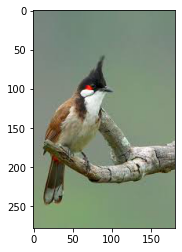

Bird breed is RED WISKERED BULBUL
dataset/int/2.jpg


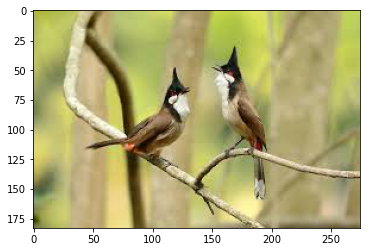

Bird breed is PEREGRINE FALCON
dataset/int/3.jpg


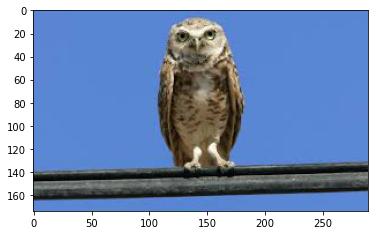

Bird breed is VIOLET GREEN SWALLOW
dataset/int/4.jpg


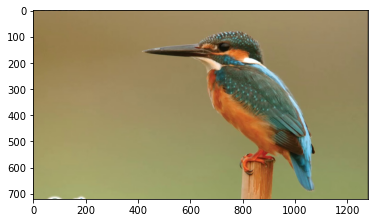

Did not find any bird!
dataset/int/5.jpg


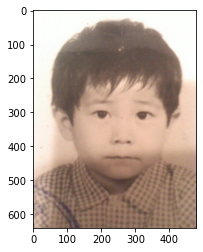

Did not find any bird!
dataset/int/6.JPG


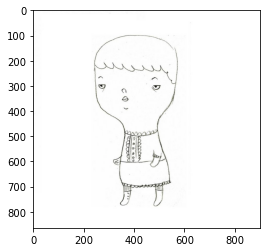

Bird breed is VIOLET GREEN SWALLOW
dataset/int/7.jpg


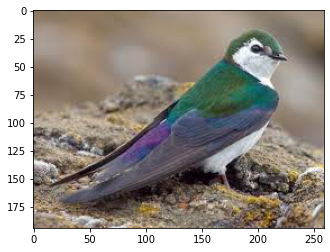

In [75]:
import os
import matplotlib.pyplot as plt 
from PIL import Image
    
for img_file in os.listdir('dataset/int/'):
    img_path = os.path.join('dataset/int/', img_file)
    run_app(img_path)
    print(img_path)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()

# Model Improvement
To increase the accurcy of classification, the bolew method may also helpful but it cost more GPU power.
 1. Increase the number of epoch 
 2. Increase the number of Convolution layer
 3. More training image will help to increase the accurcy of classification
 4. Try different kind of train model like ResNet152V2, ResNet50V2 or NASNetLarge.